In [120]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from c3.utils.tf_utils import tf_project_to_comp
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *

In [145]:
dir = 'output_0'
sim_res = 10e9
qubit_levels = [4, 4]

level_labels_transmon = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle"]
for i in range(len(level_labels_transmon), max(qubit_levels)):
    level_labels_transmon.append("leakage")
level_labels = []
level_labels_with_leakage = []
level_labels_short = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 3 or j > 3:
            level_labels_with_leakage.append("leakage")
            level_labels_short.append(None)
        else:
            s = f"${level_labels_transmon[i]},{level_labels_transmon[j]}$"
            level_labels.append(s)
            level_labels_with_leakage.append(s)
            level_labels_short.append(f"{i},{j}")
level_labels_transmon = [f"${x}$" for x in level_labels_transmon]

In [147]:
# load and print propagator
propagator = np.load(f'{dir}/propagator_after.npy')
partial = np.load(f'{dir}/partial_propagators_after.npy')
plotComplexMatrixHinton(propagator, maxAbsolute=1, xlabels=level_labels_short, ylabels=level_labels_short,
                        gridColour="gray", colourMap='hsv')

ValueError: cannot reshape array of size 536568 into shape (3000,16,16)

(16, 3001)


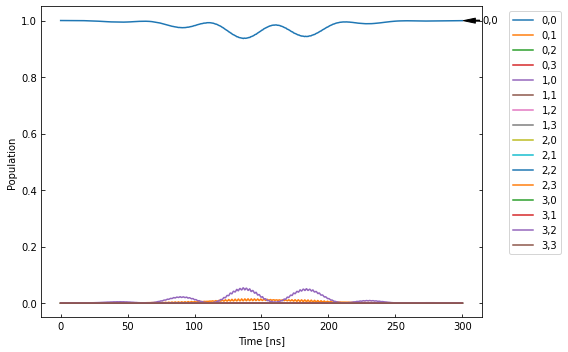

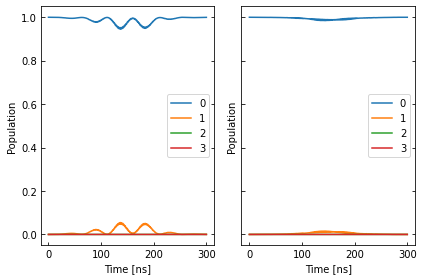

(1, 3001)


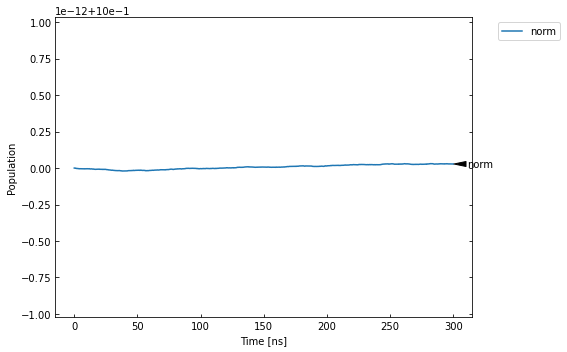

In [150]:
def calculatePopulation(dUs, psi_init: tf.Tensor) -> np.array:
    psi_t = psi_init
    pop_t = tf.abs(psi_t) ** 2
    for du in dUs:
        psi_t = np.matmul(du, psi_t)
        pops = tf.abs(psi_t) ** 2
        pop_t = np.append(pop_t, pops, axis=1)
    return pop_t


def calculateObservable(dUs, psi_init, function: Callable) -> np.array:
    psi_t = psi_init
    pop_t = np.array(function(psi_t))
    for du in dUs:
        psi_t = np.matmul(du, psi_t)
        pop_t = np.append(pop_t, function(psi_t))
    return pop_t


def plotPopulation(
        population: np.array,
        labels: List[str] = None,
        labelX: str = "Time [ns]",
        labelY: str = "Population"
):
    """
    Plots time dependent populations. They need to be calculated with `runTimeEvolution` first.
    Parameters
    ----------
    exp: Experiment
        The experiment containing the model and propagators
    population: np.array
        The population
    sequence: List[str]
        List of gate names that will be applied to the state
    labels: List[str]
        Optional list of names for the levels. If none, the default list from the experiment will be used.
    vertical_lines: bool
        If true, this add a dotted vertical line after each gate
    filename: str
        Optional name of the file to which the plot will be saved. If none,
        it will only be shown.
    """
    # timestamps
    dt = 1.0 / sim_res
    ts = np.linspace(0.0, dt * population.shape[1], population.shape[1])

    # create the plot
    fig, axs = plt.subplots(1, 1, figsize=[8, 5])
    axs.plot(ts * 1e9, population.T)

    print(population.shape)
    for i in range(population.shape[0]):
        endVal = population[i, -1]
        if endVal > 0.1:
            axs.annotate(labels[i], xy=(ts[-1] * 1e9, endVal), xycoords='data',
                         xytext=(1.07 * (ts[-1] * 1e9), endVal), textcoords='data',
                         arrowprops=dict(width=1, headwidth=5, facecolor='black', shrink=0.05),
                         horizontalalignment='center', verticalalignment='center',
                         )

    # set plot properties
    axs.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
    axs.set_xlabel(labelX)
    axs.set_ylabel(labelY)
    if labels is not None:
        plt.legend(
            labels,
            ncol=1,
            bbox_to_anchor=(1.05, 1.0),
            loc="upper left",
        )
    plt.tight_layout()

    # show and save
    plt.show()


def plotSplittedPopulation(population: np.array) -> None:
    splitted = getQubitsPopulation(population, qubit_levels)

    # timestamps
    dt = 1.0 / sim_res
    ts = np.linspace(0.0, dt * population.shape[1], population.shape[1])

    # create both subplots
    fig, axs = plt.subplots(1, len(splitted), sharey="all")
    for idx, ax in enumerate(axs):
        ax.plot(ts / 1e-9, splitted[idx].T)
        ax.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
        ax.set_xlabel("Time [ns]")
        ax.set_ylabel("Population")
        ax.legend([str(x) for x in np.arange(qubit_levels[idx])])

    plt.tight_layout()

    # show and save
    plt.show()
    plt.close()


def getInitialState(basisStates: List[int]) -> tf.Tensor:
    psi_init = [[0] * np.prod(qubit_levels)]
    for i in basisStates:
        psi_init[0][i] = 1
    psi_init /= np.linalg.norm(psi_init)
    return tf.transpose(tf.constant(psi_init, tf.complex128))


init_state = getInitialState([0])
populations = calculatePopulation(partial, init_state)
plotPopulation(populations, labels=level_labels_short)
plotSplittedPopulation(populations)

norm = calculateObservable(partial, init_state, lambda psi: tf.math.real(tf.norm(psi)))
plotPopulation(norm.reshape(1,len(norm)), labels=["norm"])


(1, 3001)


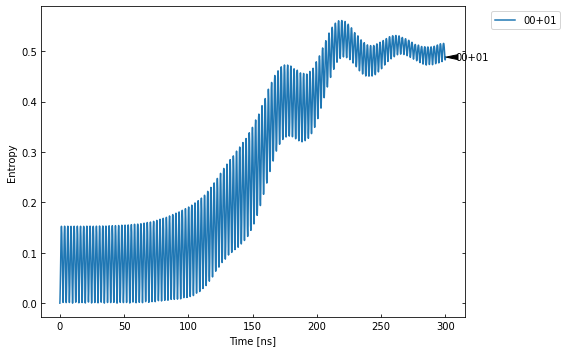

(1, 3001)


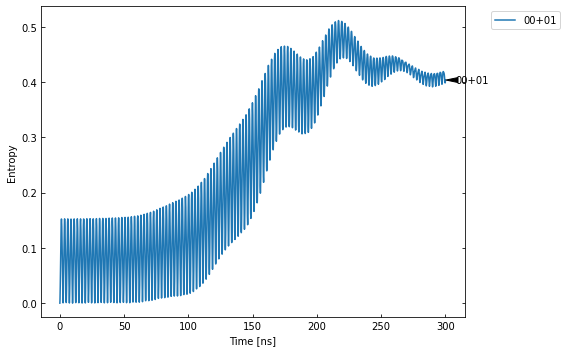

[-0.          0.00459509  0.01530948 ...  0.48293344  0.48485154
  0.48824824]
[-0.          0.00456647  0.01522135 ...  0.39905233  0.4008507
  0.40379505]


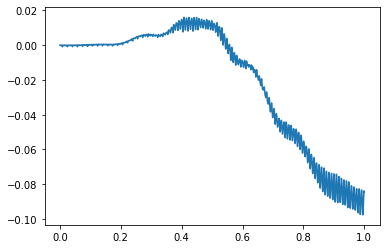

In [144]:
def entropyB(state: tf.Tensor):
    rho = densityMatrix(state)
    #rho = tf_project_to_comp(rho, dims=[5] * 2, outdims=[4] * 2)
    rhoBD = partialTrace(rho, [1, 3])
    rhoB = partialTrace(rhoBD, [0])
    #rhoAB = partialTrace(rho, [0, 1])
    return entanglementEntropy(rhoB)  # - entanglementEntropy(rhoBD)


def entropyBD(state: tf.Tensor):
    rho = densityMatrix(state)
    #rho = tf_project_to_comp(rho, dims=[5] * 2, outdims=[4] * 2)
    rhoBD = partialTrace(rho, [1, 3])
    #rhoB = partialTrace(rhoBD, [0])
    #rhoAB = partialTrace(rho, [0, 1])
    return entanglementEntropy(rhoBD)


def entropyBmBD(state: tf.Tensor):
    rho = densityMatrix(state)
    #rho = tf_project_to_comp(rho, dims=[5] * 2, outdims=[4] * 2)
    rhoBD = partialTrace(rho, [1, 3])
    rhoB = partialTrace(rhoBD, [0])
    #rhoAB = partialTrace(rho, [0, 1])
    return entanglementEntropy(rhoB) - entanglementEntropy(rhoBD)


def entropyBproj(state: tf.Tensor):
    rho = densityMatrix(state)
    rho = tf_project_to_comp(rho, dims=[2, 2, 2, 2], outdims=[0, 2, 0, 2])
    rhoB = partialTrace(rho, [0])
    #rhoAB = partialTrace(rho, [0, 1])
    return entanglementEntropy(rhoB)


def printEntanglementEvolution(dUs, state, entropyFunction):
    entropy = calculateObservable(dUs, state, entropyFunction)
    entropy = entropy.reshape((1, len(entropy)))
    plotPopulation(entropy, labels=["00+01", "00+10", "01+11", "10+11"], labelY="Entropy")


init_state = getInitialState([1])
printEntanglementEvolution(partial, init_state, entropyB)
#printEntanglementEvolution(partial, init_state, entropyBD)
#printEntanglementEvolution(partial, init_state, entropyBmBD)
printEntanglementEvolution(partial, init_state, entropyBproj)
SB = calculateObservable(partial, init_state, entropyB)
print(SB)
SBproj = calculateObservable(partial, init_state, entropyBproj)
print(SBproj)
y = SBproj - SB
plt.figure()
plt.plot(np.linspace(0, 1, len(y)), y)
plt.show()